## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.1.0


In [2]:
def kernel(x1,x2,l = 0.3):
    return np.exp(-1.0/l**2*(np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2)

def kernelTF(x1,x2,l = 0.3):
    return tf.exp(-1.0/l**2*(tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2)

def GP(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = kernel(x,X)
    return 2*(np.squeeze(np.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

def GPTF(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = k_xX = kernelTF(x,X)
    return 2*(tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

In [3]:
def gen_data(n_train, n_test, n_gp_samples = 8):
    
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))
    X[:,0] = -1.0
    X[:,-1] = 1.0
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))

    # Compute and invert the GP Kernel Matrix
    K_XX = kernel(X,X)
    A = np.linalg.inv(K_XX)
    A = np.matmul(A,np.expand_dims(Y,axis=2))
    
    # Compute min and max value of GP
    x = np.linspace(-1,1,100).reshape(1,-1)
    y = GP(X, A, x)
    min_val = np.min(y,1).reshape(-1,1)
    max_val = np.max(y,1).reshape(-1,1)
    
    # Rescale to [-1,1]
    Y = 2*(Y-min_val)/(max_val-min_val)-1
    
    return (X, Y, A, min_val, max_val)

def plot_training_data(X, A, min_val, max_val):
    x = np.linspace(-1,1,100).reshape(1,-1)
    y = GP(X, A, x, min_val, max_val)
    plt.figure(figsize=(20,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.plot(x.flatten(),y[i])
        plt.scatter(X[i],Y[i])
    plt.show()

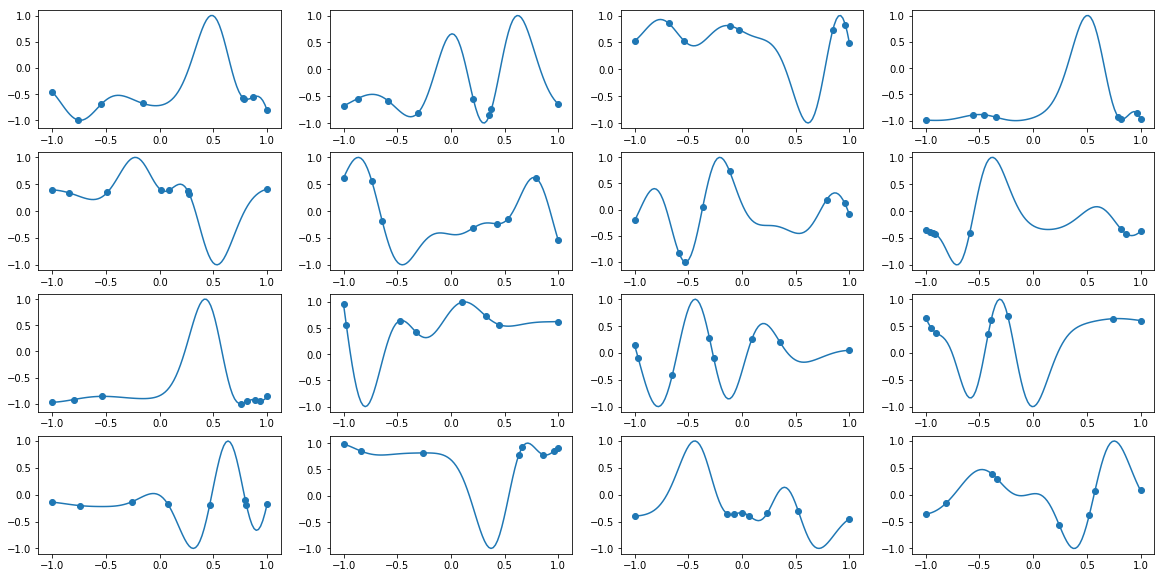

In [4]:
n_train = 1600
n_test = 160

X, Y, A, min_val, max_val = gen_data(n_train, n_test, n_gp_samples=8)

X_train, Y_train, A_train, min_train, max_train =\
        X[:n_train], Y[:n_train], A[:n_train], min_val[:n_train], max_val[:n_train]
    
X_test, Y_test, A_test, min_test, max_test =\
        X[-n_test:], Y[-n_test:], A[-n_test:], min_val[-n_test:], max_val[-n_test:]
    
plot_training_data(X_train, A_train, min_train, max_train)

In [5]:
# Number of hidden states in RNN cell
n_hidden = 50

# Sequence length
num_steps = 20

In [6]:
# LSTM Output Weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, 1]))
}
biases = {
    'out': tf.Variable(tf.random_normal([1]))
}

In [7]:
# Create Model
size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, 8])
At = tf.placeholder(tf.float32, [None, 8, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

x_0 = -0.0*tf.ones([size, 1])
h_0 = tf.ones([size, n_hidden])
c_0 = tf.ones([size, n_hidden])

state = (c_0, h_0)
x = x_0
y = GPTF(Xt,At,x, mint, maxt)
sample_points = [x]

f_min = y
f_sum = 0

# No idea why this is necessary 
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=None)
cell(tf.concat([x, y], 1), state, scope='rnn_cell')
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=True)

for i in range(num_steps):
    h, state = cell(tf.concat([x, y], 1), state, scope='rnn_cell')
    x = tf.tanh(tf.matmul(h, weights['out']) + biases['out'])
    sample_points.append(x)
    
    y = GPTF(Xt,At,x, mint, maxt)
    
    f_min = tf.minimum(y, f_min)
    f_sum += tf.reduce_mean(y)

f_min = tf.reduce_mean(f_min)
loss = f_sum / num_steps

In [8]:
# Define Optimizer
learning_rate = 0.00003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [18]:
# Start Session and Initialize
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_loss_list = []
test_loss_list = []
train_fmin_list = []
test_fmin_list = []

In [19]:
# Train the Network
epochs = 800
batch_size = 160

print("Number of Training Samples: "+str(n_train))
print("Batch size: "+str(batch_size))
print("Number of hidden Units: "+str(n_hidden))
print("Sequence length: "+ str(num_steps))
print("Learning rate: "+str(learning_rate))

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
        A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
        min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
        max_batch = max_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={Xt: X_batch, At: A_batch, size: batch_size, mint: min_batch, maxt: max_batch})
    
    train_loss, train_fmin = sess.run([loss, f_min], \
                          feed_dict={Xt: X_train, At: A_train, size: n_train, mint: min_train, maxt: max_train})

    test_loss, test_fmin = sess.run([loss, f_min], \
                                    feed_dict={Xt: X_test, At: A_test, size:n_test, mint: min_test, maxt: max_test})
    
    train_loss_list += [train_loss]
    test_loss_list += [test_loss]
    train_fmin_list += [train_fmin]
    test_fmin_list += [test_fmin]
    
    if ep < 10 or ep % (epochs // 10) == 0 or ep == epochs-1:
        print("Ep: " +"{:4}".format(ep)+" | TrainLoss: "+"{: .3f}".format(train_loss)
              +" | TrainMin: "+ "{: .3f}".format(train_fmin)+ " | TestLoss: "+
              "{: .3f}".format(test_loss)+" | TestMin: "+ "{: .3f}".format(test_fmin)+" |")
        
    if train_fmin < -0.99:
        print("Stopped training: TrainMin < -0.95")
        break

Number of Training Samples: 1600
Batch size: 160
Number of hidden Units: 50
Sequence length: 20
Learning rate: 3e-05
Ep:    0 | TrainLoss: -0.015 | TrainMin: -0.397 | TestLoss: -0.063 | TestMin: -0.339 |
Ep:    1 | TrainLoss: -0.023 | TrainMin: -0.406 | TestLoss: -0.070 | TestMin: -0.348 |
Ep:    2 | TrainLoss: -0.032 | TrainMin: -0.417 | TestLoss: -0.079 | TestMin: -0.359 |
Ep:    3 | TrainLoss: -0.043 | TrainMin: -0.429 | TestLoss: -0.090 | TestMin: -0.373 |
Ep:    4 | TrainLoss: -0.056 | TrainMin: -0.441 | TestLoss: -0.102 | TestMin: -0.388 |
Ep:    5 | TrainLoss: -0.071 | TrainMin: -0.456 | TestLoss: -0.115 | TestMin: -0.407 |
Ep:    6 | TrainLoss: -0.086 | TrainMin: -0.472 | TestLoss: -0.125 | TestMin: -0.425 |
Ep:    7 | TrainLoss: -0.099 | TrainMin: -0.487 | TestLoss: -0.131 | TestMin: -0.441 |
Ep:    8 | TrainLoss: -0.112 | TrainMin: -0.501 | TestLoss: -0.138 | TestMin: -0.457 |
Ep:    9 | TrainLoss: -0.123 | TrainMin: -0.512 | TestLoss: -0.146 | TestMin: -0.469 |
Ep:   80 | Tr

In [11]:
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(num_steps+1,n_train).T
samples_test = sess.run([sample_points], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(num_steps+1,n_test).T

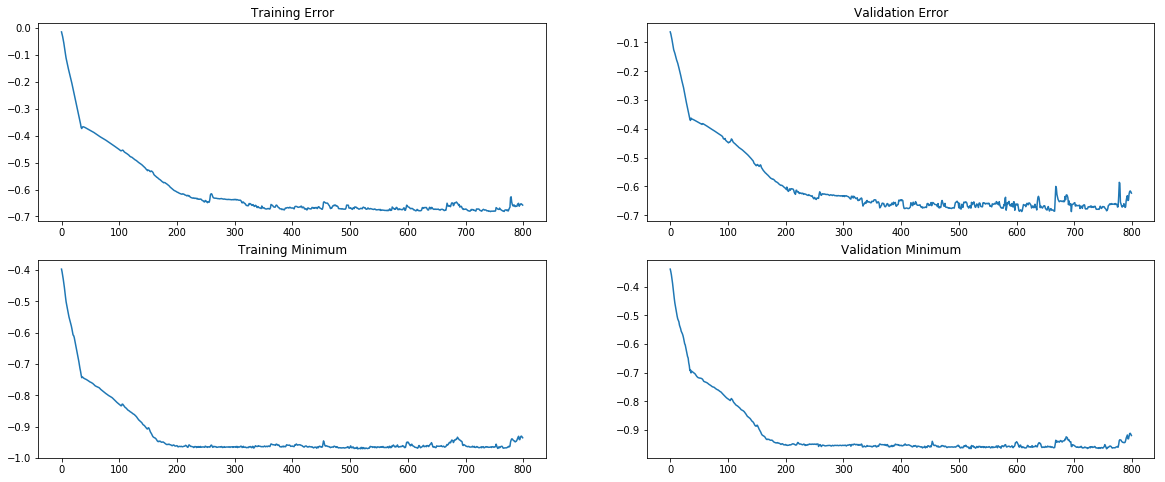

In [21]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(train_loss_list)
plt.title("Training Error")
plt.subplot(2,2,2)
plt.plot(test_loss_list)
plt.title("Validation Error")
plt.subplot(2,2,3)
plt.plot(train_fmin_list)
plt.title("Training Minimum")
plt.subplot(2,2,4)
plt.plot(test_fmin_list)
plt.title("Validation Minimum")
plt.show()

In [13]:
def plot_multiple(traintest="train"):
    if traintest == "train":
        X, A, minv, maxv = (X_train, A_train, min_train, max_train)
        title_str = "Training Data"
        samples = samples_train
        nf = n_train
    else:
        X, A, minv, maxv  = (X_test, A_test, min_test, max_test)
        title_str = "Test Data"
        samples = samples_test
        nf = n_test
      
    xx = np.linspace(-1,1,200)
    
    idx = np.random.choice(list(range(nf)),16, replace=False)
    plt.figure(figsize=(20,10))
    for count, i in enumerate(idx):        
        samples_x = samples[i]
        samples_y = GP(X[i].reshape(1,-1),A[i],samples_x, minv[i], maxv[i]).flatten()
        yy = GP(X[i].reshape(1,-1),A[i],xx, minv[i], maxv[i]).flatten()
        plt.subplot(4,4,count+1)
        plt.plot(xx,yy,linewidth=3)
        plt.scatter(samples_x,samples_y,color="k")
        for j in range(1+num_steps):
            plt.text(samples_x[j], samples_y[j], str(j), color="red", fontsize=12)
        
    plt.suptitle(title_str)
    plt.show()

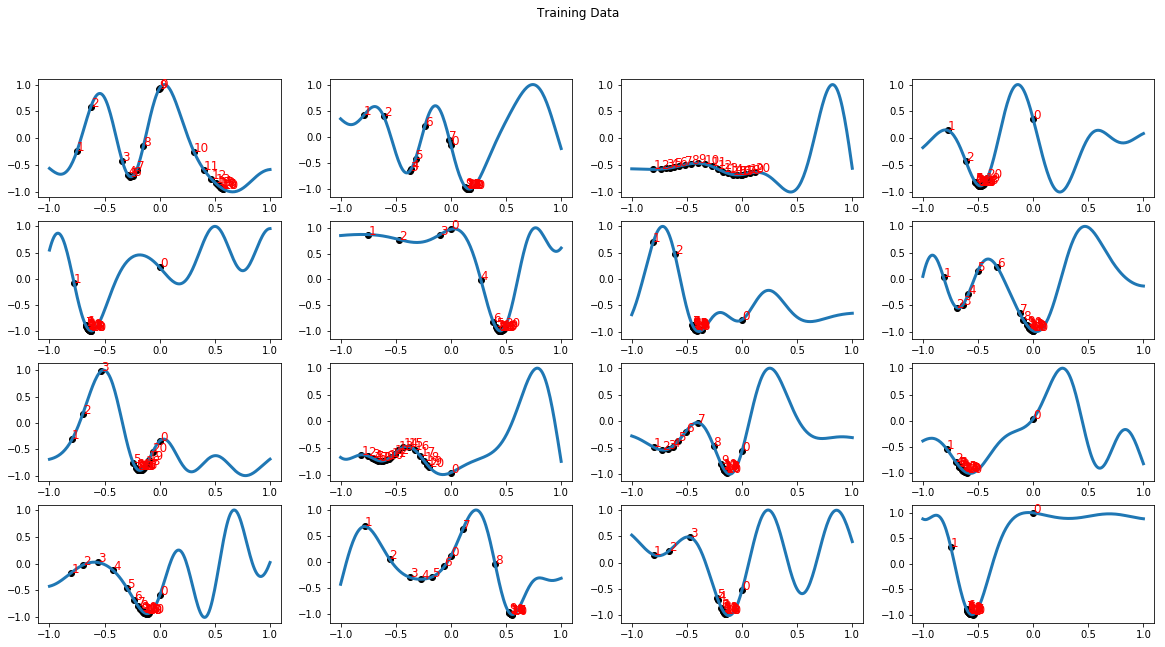

In [17]:
plot_multiple("train")

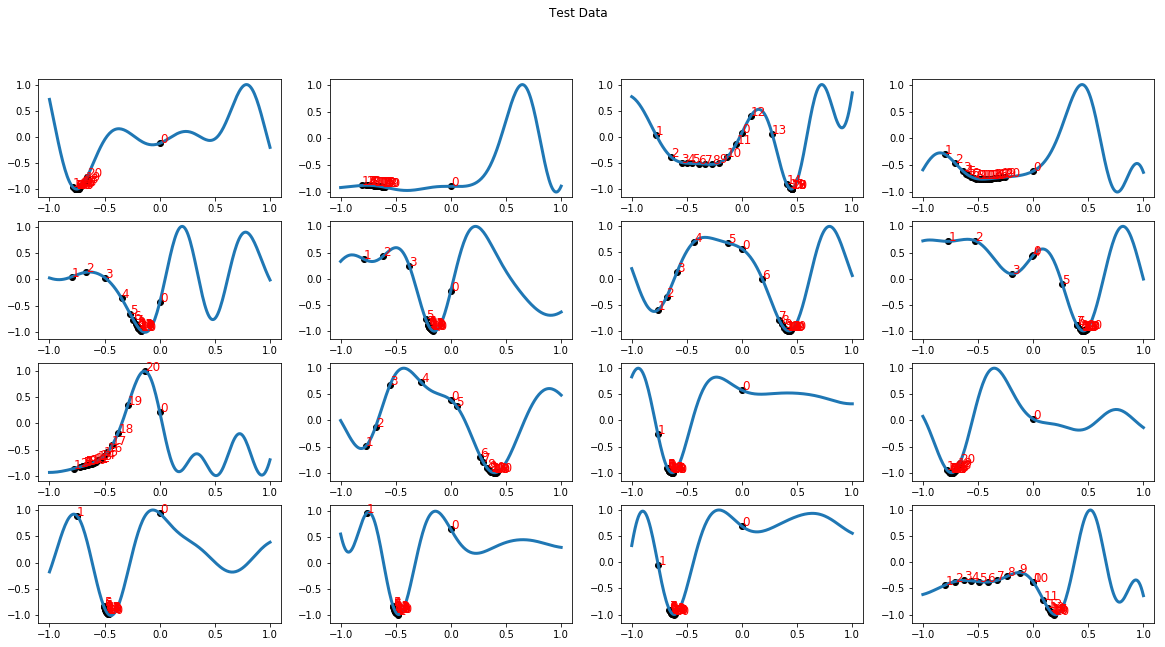

In [15]:
plot_multiple("test")